In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import unicodeit
import ipywidgets as widgets
from ipywidgets import interact

nest.set_verbosity('M_ERROR') 


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



# single PSP sum
this shows we can move peak voltage times. i included a slider for the inhibitory weight to show that changing the synaptic weight impacts the size of the shift considerably. what does this mean?

In [2]:
def mso_two_inputs(
    delta_inh=-0.4,
    tone=100,
    tau_rise_exc=0.2,
    tau_rise_in=0.2,
    tau_decay_ex=0.5,
    tau_decay_in=1.5,
    weight_exc=4,
    weight_inh=-4,
    I_ext=0,
    time_sim=15,
    v_th=-40,
    c_mso=1,
):
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01
    delay_exc = 5
    delay_inh = 5 + delta_inh

    ipsi_e = nest.Create(
        "spike_generator",
        params={"spike_times": np.around(np.arange(1, time_sim + 1, 1000 / tone), 2)},
    )
    mso = nest.Create(
        "iaf_cond_beta",
        params={
            "V_th": v_th,
            "C_m": c_mso,
            "tau_rise_ex": tau_rise_exc,
            "tau_rise_in": tau_rise_in,
            "tau_decay_ex": tau_decay_ex,
            "tau_decay_in": tau_decay_in,
            "I_e": I_ext,
        },
    )
    m = nest.Create("multimeter", 1, {"record_from": ["V_m"], "interval": 0.01})

    nest.Connect(m, mso, "all_to_all")
    nest.Connect(
        ipsi_e, mso, "one_to_one", syn_spec={"weight": weight_exc, "delay": delay_exc}
    )
    nest.Connect(
        ipsi_e, mso, "one_to_one", syn_spec={"weight": weight_inh, "delay": delay_inh}
    )
    nest.Simulate(time_sim)
    pot = m.get("events")
    # returns an array of voltages which is the potential of the MSO
    return pot

peak distance (tₙₒ₋ᵢₙₕ−tᵢₙₕ) = −1.0


interactive(children=(FloatSlider(value=-0.4, description='delta_t', max=1.0, min=-1.5), IntSlider(value=-4, d…

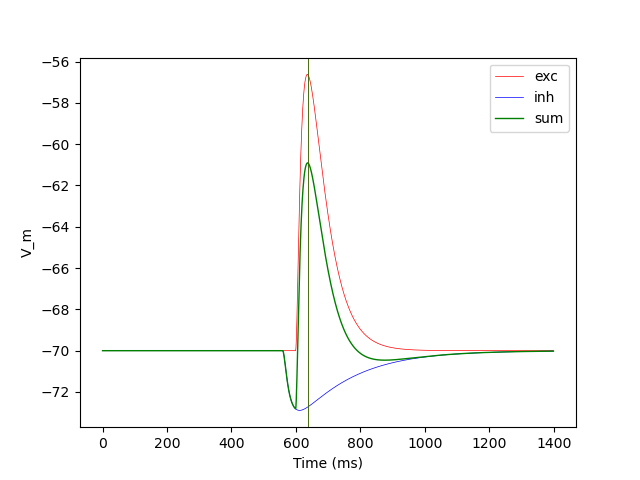

In [14]:
def show_mso_two_inputs(delta_t, weight_inh):
    [l.remove() for l in ax.lines]
    only_ex = mso_two_inputs(delta_inh=delta_t, weight_inh=0)
    only_inh = mso_two_inputs(delta_inh=delta_t, weight_inh=weight_inh, weight_exc=0)
    res_sum = mso_two_inputs(delta_inh=delta_t, weight_inh=weight_inh)
    time_max_voltage = lambda x: x["times"][np.argmax(x["V_m"])] * 100
    max_only_ex = time_max_voltage(only_ex)
    max_sum = time_max_voltage(res_sum)
    ax.plot(only_ex["V_m"], color="r", linewidth=0.5, label="exc")
    ax.plot(only_inh["V_m"], color="b", linewidth=0.5, label="inh")
    ax.plot(res_sum["V_m"], color="g", linewidth=1, label="sum")
    ax.set_xlabel("Time (ms)")
    ax.legend()
    ax.set_ylabel("V_m")
    ax.axvline(max_only_ex, color="r", linewidth=0.5)
    ax.axvline(max_sum, color="g", linewidth=0.5)
    print(
        unicodeit.replace(f"peak distance (t_{{no-inh}}-t_{{inh}}) = {max_only_ex - max_sum}")
    )


fig, ax = plt.subplots(1, 1)
default_delta_t = -0.4
default_weight_inh = -4
show_mso_two_inputs(default_delta_t, default_weight_inh)

interact(
    show_mso_two_inputs,
    delta_t=widgets.FloatSlider(min=-1.5, max=1, step=0.1, value=default_delta_t),
    weight_inh=widgets.IntSlider(min=-20, max=0, step=1, value=default_weight_inh),
)

None  # avoid printing stuff